# OVERVIEW:

Worldwide the anime industry is valued at USD 34.06 billion, and is expected to grow to over USD 110.82 billion by the end of 2037. Among the fandom there has always been a debate on how well the industry production trends align with the interest of its fandom. This project will utilize data from anilist.co to measure trends in the anime industry as it relates to genres, original sources, and other meta data indicators (e.g. tags). We will look at the frequency of these markers as well as aggregate user data representing the popularity of each of the markers.

## Scope of Project:

We will limit ourselves to more modern trends focusing on the twenty year period of 2005 until the end of 2024.

- What **original sources** have had the most representation within the industry?
    - Sources include Manga, Light Novels, Visual Novels, Video Games, Originals, and others.
    - How do these trends resonate with the anime community? Are there any categories under represented by the industry? Do the feeling of the outspoken anime community match the reality of show popularity, or does the silent majority align more closely to the decisions the industry makes?
- What **genres** have had the most representation within the industry? 
    - Included genres are Action, Adventure, Comedy, Drama, Ecchi, Fantasy, Horror, Mahou Shoujo, Mecha, Music, Mystery, Psychological, Romance, Sci-Fi, Slice of Life, Sports, Supernatural, and Thriller.
    - We'll look at a stand out shows that caused an increase of production and find out if the industry has been able to capture the same outcome.
- As well as some **media tags** that have affected the industry in the minds of fans and corporate trends alike.
    - Media tags included are Otaku Culture, Love Triangle, Kaiju, Cute Girls Doing Cute Things, Isekai, Reincarnation, Iyashikei, Exorcism, Fashion, Super Hero, and Super Robot.
    - Much like in the genres section we will look at a category that experienced a boom following a popular show and see if it was capable of maintaining the same momentum as the industry tried to keep up.

## Known Limitations:

 - We will eliminate shows with a popularity score less than 5000, to remove a lot of titles lacking enough data to shape our discussion.
 - For our purposes "popularity" will refer to the number of times a member of anilist has added a show to a list.
     - This means any designation including currently watching, completed, planned to watch, and dropped.
     - This was chosen over a subjective metric like average rating because the number of eyes on a show better reflects the effectiveness of a genre, source, or tag to draw attention, be it positive or negative.
 - Anilist is primarily a western English speaking platform; we can assume that this will be reflected in the accumulated popularity metrics.
 - Anilist includes hundreds of tags in its library. I have chosen a select few based on common observances in community conversation. We ignored tags that were better represented in genres, as well as tags referring to demographics such as Shonen, Shojo, etc. There were also tags that were decidedly not represented enough to be included in this analysis.


In [10]:
import pandas as pd
import requests
import json
import sqlite3
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import re as re
import seaborn as sns
from ast import literal_eval

# Introduction of our Data:

We will be utilizing data that was compiled from https://anilist.co using their graphQL API. You can find the functions to call the list in compile_list.ipynb.
Here we will use the pre-compiled list from complete_anilist.csv. This data was compiled in early 2025, and only includes shows that were marked as the finished status.

## Import Data:

In [9]:
df = pd.read_csv("complete_anilist.csv")
df

,id,type,format,status,seasonYear,source,genres,popularity,tags,title.english,title.romaji
0,1,ANIME,TV,FINISHED,1998.0,ORIGINAL,"['Action', 'Adventure', 'Drama', 'Sci-Fi']",380694,"[{'name': 'Space'}, {'name': 'Crime'}, {'name'...",Cowboy Bebop,Cowboy Bebop
1,5,ANIME,MOVIE,FINISHED,2001.0,ORIGINAL,"['Action', 'Drama', 'Mystery', 'Sci-Fi']",70431,"[{'name': 'Terrorism'}, {'name': 'Primarily Ad...",Cowboy Bebop: The Movie - Knockin' on Heaven's...,Cowboy Bebop: Tengoku no Tobira
2,6,ANIME,TV,FINISHED,1998.0,MANGA,"['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...",136780,"[{'name': 'Guns'}, {'name': 'Fugitive'}, {'nam...",Trigun,TRIGUN
3,7,ANIME,TV,FINISHED,2002.0,ORIGINAL,"['Action', 'Drama', 'Mystery', 'Supernatural']",18663,"[{'name': 'Conspiracy'}, {'name': 'Police'}, {...",Witch Hunter ROBIN,Witch Hunter ROBIN
4,8,ANIME,TV,FINISHED,2004.0,MANGA,"['Adventure', 'Fantasy', 'Supernatural']",2614,"[{'name': 'Shounen'}, {'name': 'Spearplay'}, {...",Beet the Vandel Buster,Bouken Ou Beet
...,...,...,...,...,...,...,...,...,...,...,...
18386,186761,ANIME,MOVIE,FINISHED,NaN,OTHER,"['Comedy', 'Drama']",3,[],NaN,Ban Ye Ji Jiao
18387,186762,ANIME,MOVIE,FINISHED,NaN,OTHER,['Comedy'],4,[],NaN,Cao Chong Cheng Xiang
18388,186763,ANIME,MOVIE,FINISHED,NaN,OTHER,"['Drama', 'Fantasy']",4,[{'name': 'Dragons'}],NaN,Diao Long Ji
18389,186764,ANIME,MOVIE,FINISHED,2024.0,NaN,['Fantasy'],138,"[{'name': 'Virtual World'}, {'name': 'Female P...",NaN,SINoALICE: Ichiban Saigo no Monogatari


# Cleaning Data:

In [ ]:
def clean_list(df: pd.DataFrame) -> pd.DataFrame:
    df = df[(df.format != "MOVIE") & (df.format != "SPECIAL") & (df.format != "MUSIC") & (df.format != "TV_SHORT") & (df.format.notnull())] #remove unnecesary formats
    df['title.english'] = df['title.english'].fillna(df['title.romaji'])  #clean english title
    df_2 = df.dropna(subset=['seasonYear']) #Drop entries with no listed year.
    df_2 = df_2.drop(['title.romaji','status','type'],axis=1) #drop romaji title
    df_2['source'] = df_2['source'].fillna('OTHER') #replace unknown source with "OTHER"
    df_2['seasonYear'] = df_2['seasonYear'].astype(int)
    df_2.rename(columns={'title.english' : 'Title'}, inplace=True)    
    df_2.rename(columns={'seasonYear' : 'Year'}, inplace=True)
    df_2.columns = df_2.columns.str.capitalize()
    df_3 = df_2[(df_2['Year'] > 2004) & (df_2['Year'] <= 2024)] #Reduce scope to years between 2005 and 2025
    df_4 = df_3.drop(df_3[df_3['Popularity'] <= 5000].index) #Remove any shows that have a popularity score less than 5000
    return df_4

In [ ]:
anilist = clean_list(df)

C:\Users\Leolion023\AppData\Local\Temp\ipykernel_32232\534513342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['title.english'] = df['title.english'].fillna(df['title.romaji'])  #clean english title


In [ ]:
anilist

,Id,Format,Year,Source,Genres,Popularity,Tags,Title
5,15,TV,2005,MANGA,"['Action', 'Comedy', 'Sports']",29079,"[{'name': 'American Football'}, {'name': 'Shou...",Eyeshield 21
6,16,TV,2005,MANGA,"['Comedy', 'Drama', 'Romance', 'Slice of Life']",50455,"[{'name': 'Coming of Age'}, {'name': 'Josei'},...",Honey and Clover
16,27,TV,2005,LIGHT_NOVEL,"['Action', 'Drama', 'Horror', 'Sci-Fi', 'Super...",23424,"[{'name': 'Vampire'}, {'name': 'Male Protagoni...",Trinity Blood
30,50,TV,2005,MANGA,"['Comedy', 'Romance', 'Supernatural']",21661,"[{'name': 'Magic'}, {'name': 'Primarily Female...",Oh! My Goddess (TV)
45,65,TV,2005,MANGA,"['Action', 'Comedy', 'Drama']",14749,"[{'name': 'Battle Royale'}, {'name': 'Magic'},...",Rozen Maiden: Dreaming
...,...,...,...,...,...,...,...,...
17692,177697,ONA,2024,MANGA,"['Comedy', 'Drama', 'Sci-Fi', 'Slice of Life']",26902,"[{'name': 'Aliens'}, {'name': 'Philosophy'}, {...",DEAD DEAD DEMONS DEDEDEDE DESTRUCTION
17699,177814,ONA,2024,OTHER,"['Action', 'Sci-Fi']",8314,"[{'name': 'Robots'}, {'name': 'Post-Apocalypti...",TERMINATOR ZERO
17763,178434,TV,2024,LIGHT_NOVEL,"['Adventure', 'Fantasy']",29555,"[{'name': 'Military'}, {'name': 'Politics'}, {...","As a Reincarnated Aristocrat, I'll Use My Appr..."
17794,178533,TV,2024,MANGA,"['Action', 'Comedy', 'Romance']",38065,"[{'name': 'Gender Bending'}, {'name': 'Arrange...",Ranma1/2 (2024)


# Exploring the Data:

## Source data over the years:

Where does anime come from? All media has an origin, anime is no exception. The conventional wisdom is that the vast majority of anime have their origin manga. However, over the past several years there has been a large uptick in shows that come from light novels. Has light novel based anime taken over manga as the top source material?

Where does the best anime come from? Often it is touted that the best anime are original content with no previous work to base artistic intent. Yet, is this true, should companies be putting more effort into original content or is it better to keep pushing out as much manga and light novel content? 

The following section explores the data on these questions over the last twenty years.


In [ ]:
anilist.groupby('Source').Title.count()

Source
LIGHT_NOVEL      585
MANGA           1434
ORIGINAL         479
OTHER            201
VIDEO_GAME       180
VISUAL_NOVEL     123
Name: Title, dtype: int64

Unsurprisingly, manga has been king when it comes to number of conversions to anime. What is more interesting is that original content has kept up with light novels over the last twenty years until around 2021. Let's look at how the numbers have changed year by year.

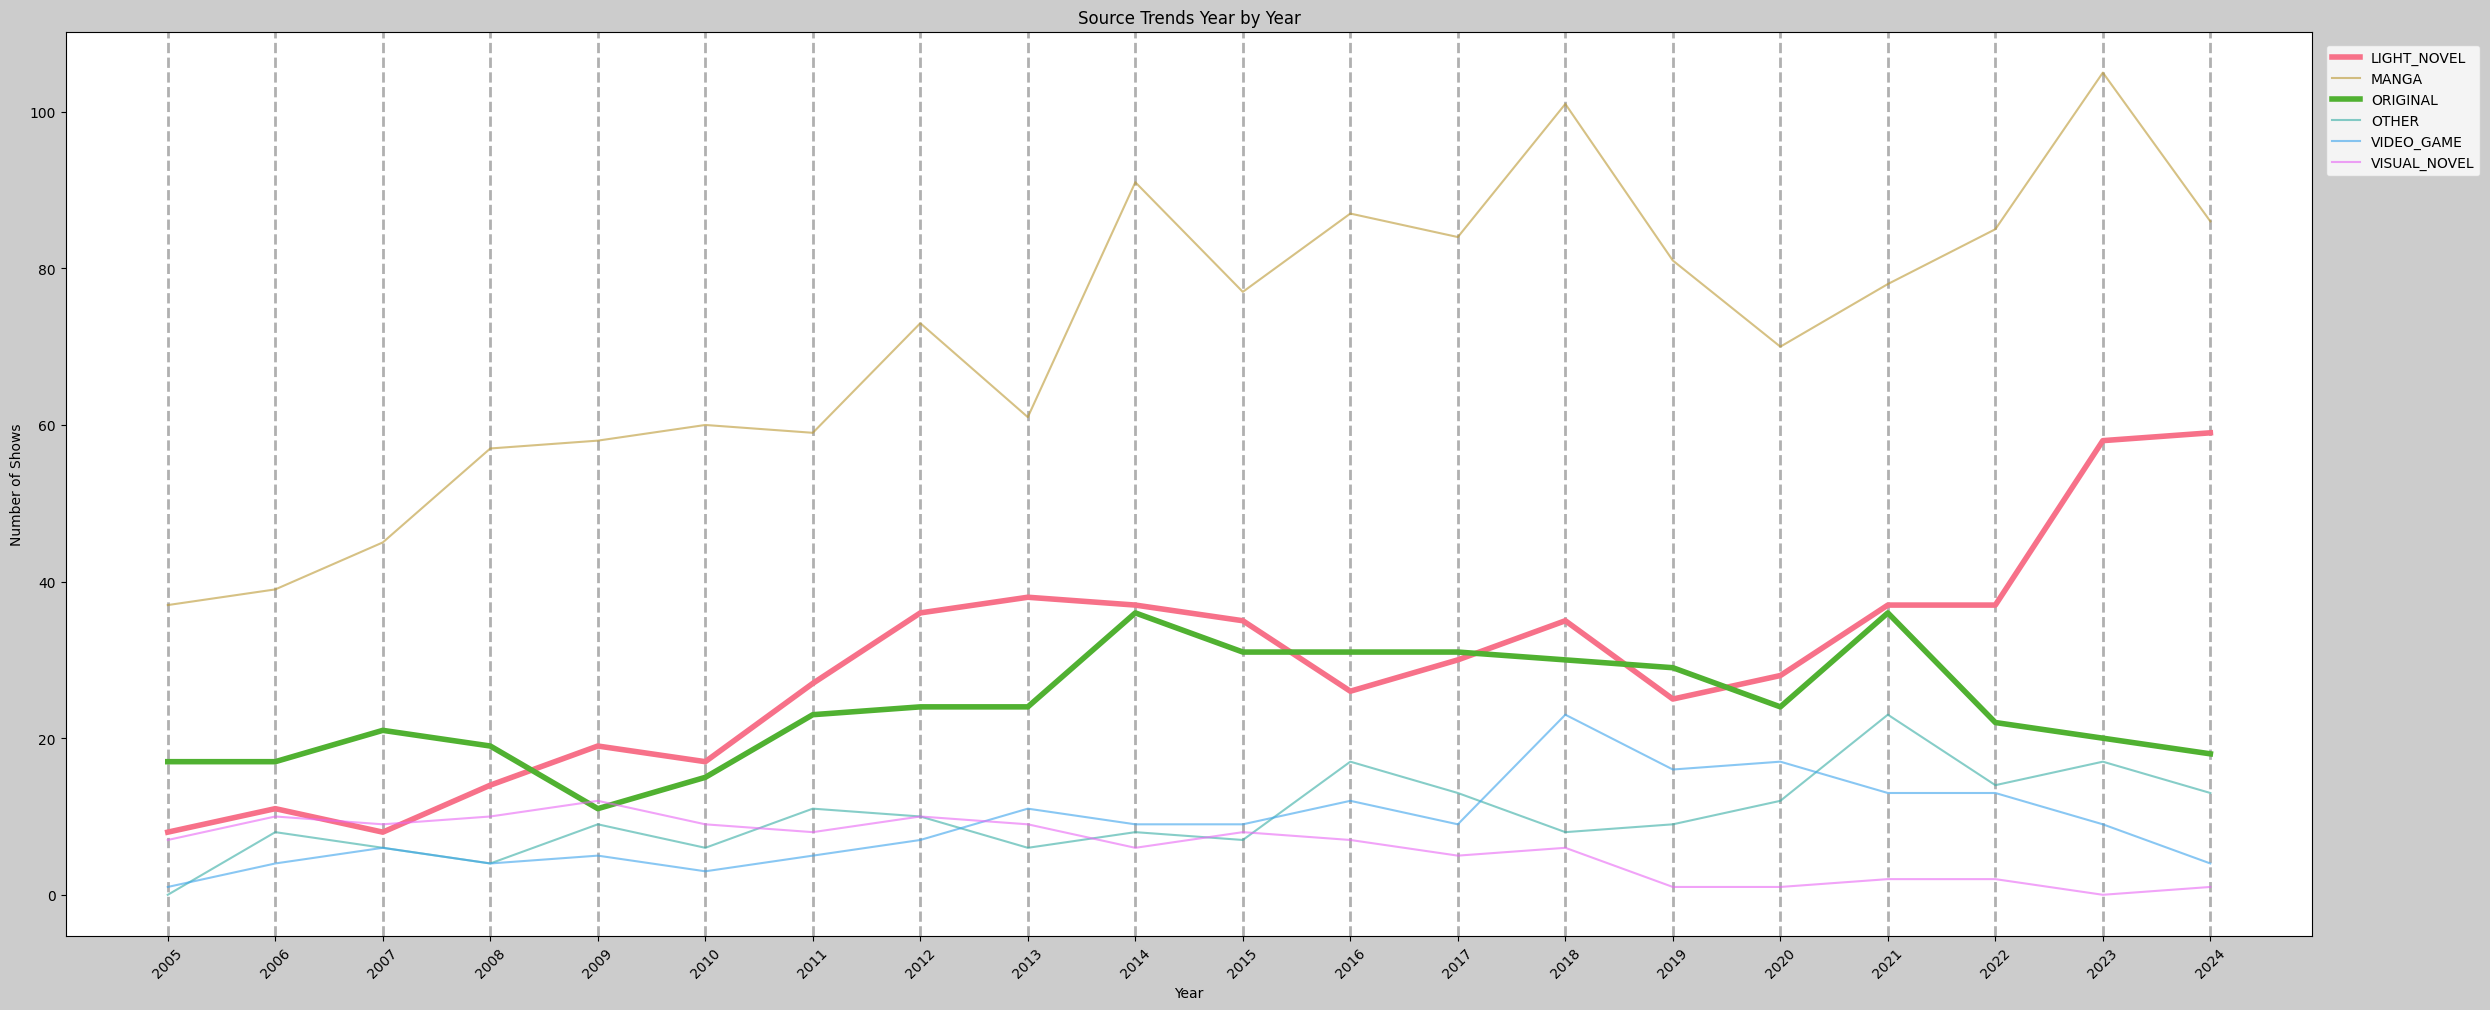

In [ ]:
# Pivot the data to have source as columns and years as index
source_trends = anilist.pivot_table(values='Title', index='Year', columns='Source', aggfunc='count', fill_value=0)
colors = sns.color_palette('husl', 6)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

# Here we create line plots for each source
for i,source in enumerate(source_trends.columns):
    if i == 0 or i == 2:
        plt.plot(source_trends.index, source_trends[source], linewidth = 4, label=source, color=colors[i % len(colors)])
    else:
        plt.plot(source_trends.index, source_trends[source], alpha = .6, label=source, color=colors[i % len(colors)])

plt.title('Source Trends Year by Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(source_trends.index), max(source_trends.index) + 1))
plt.xticks(rotation=45)

plt.show()

### Trend results:
While manga has maintained its overwhelming hold on anime sources, the growth of light novels has not been as fast or overwhelming as the community has felt. In fact up until 2023 original content has been neck and neck with light novel representation. Then why is it that there is often a lament that all the best anime are original content and yet companies continue to push boring light novel content? Let’s look and see if original content really lives up to its expectations.


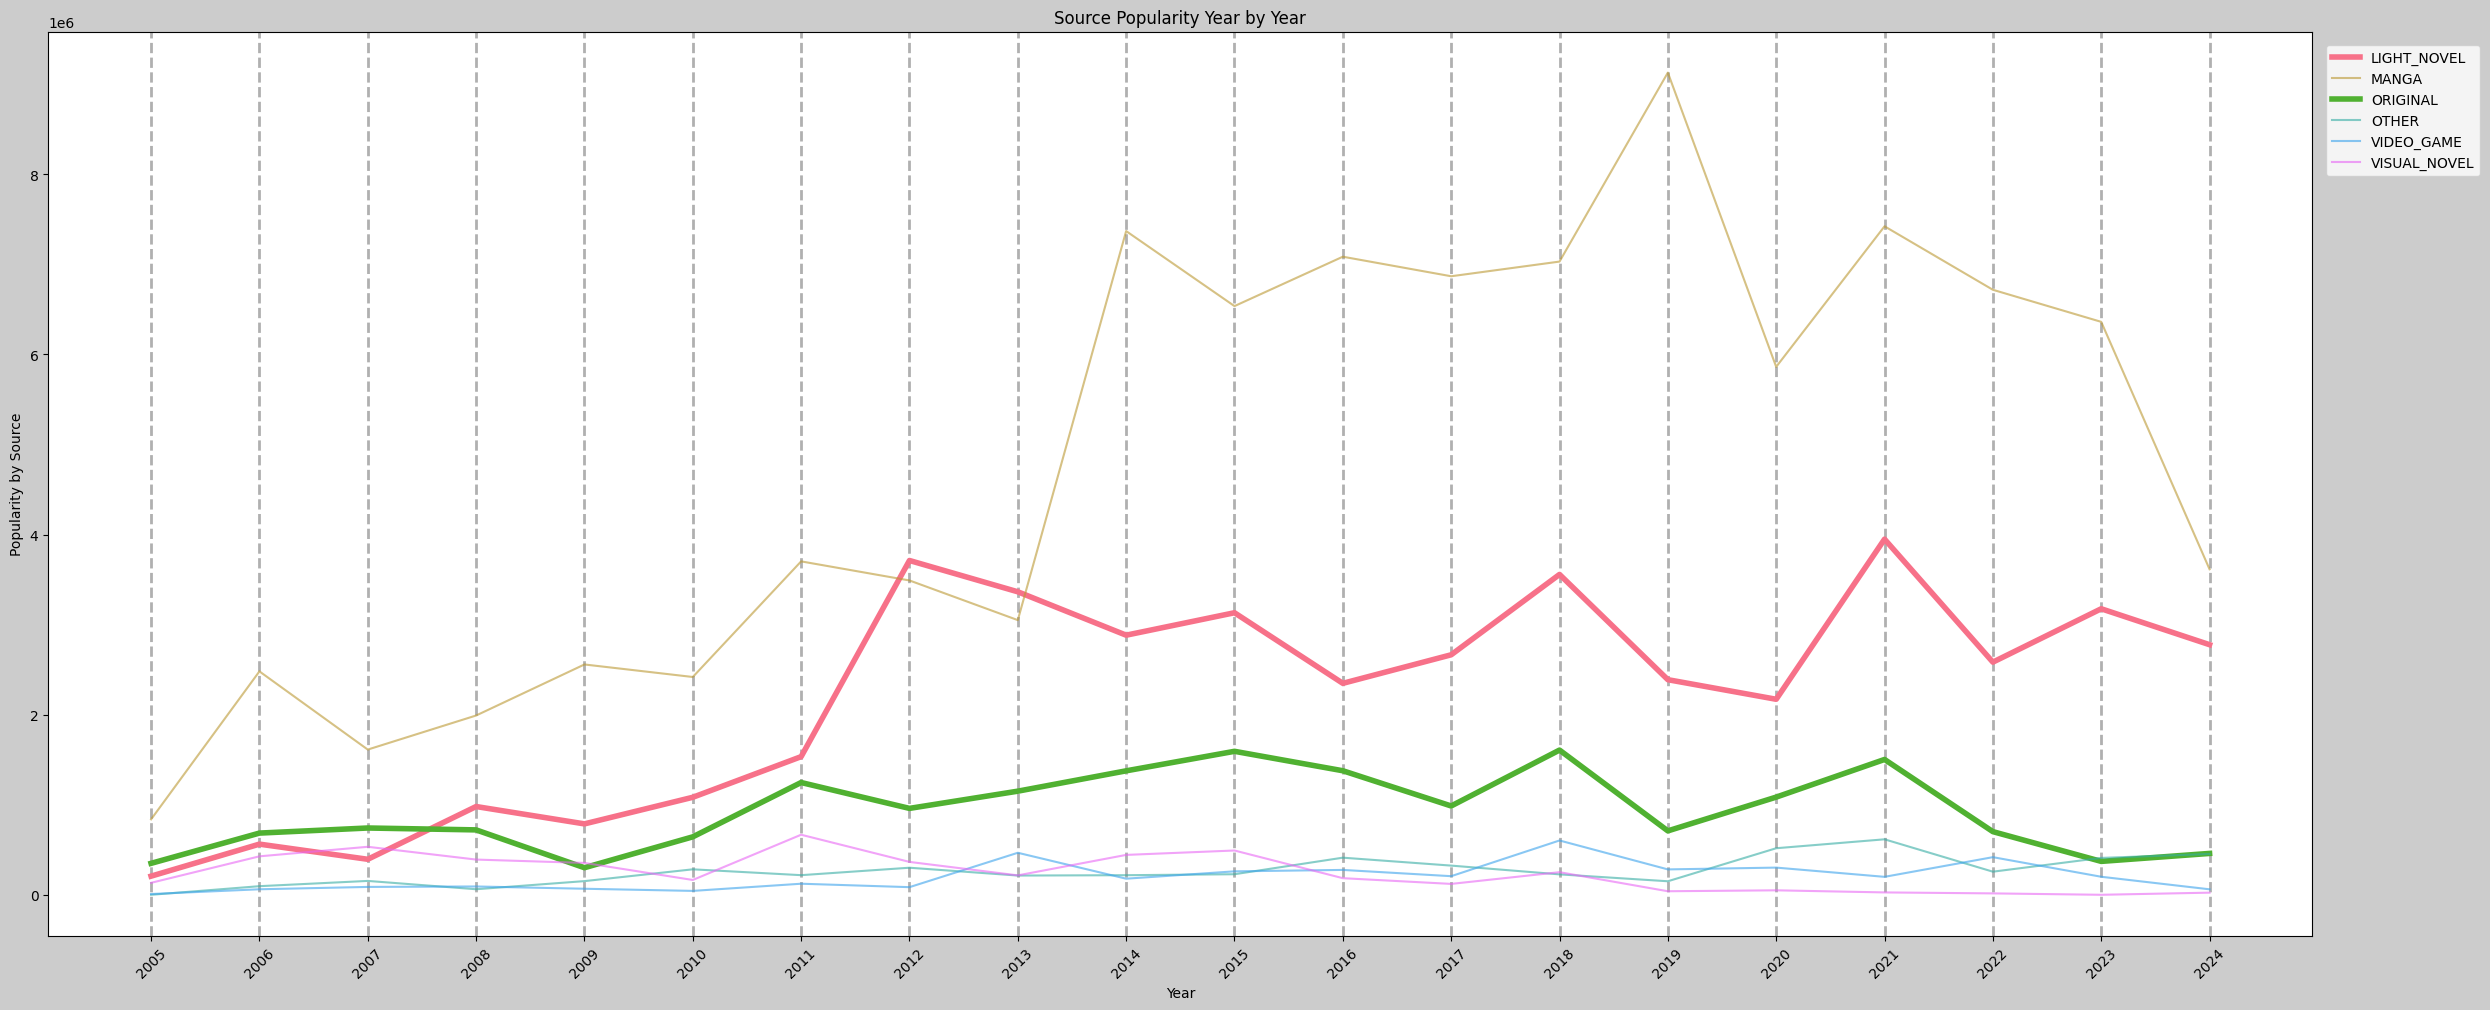

In [ ]:
# Pivot the data to have source as columns and years as index
source_popularity = anilist.pivot_table(values='Popularity', index='Year', columns='Source', aggfunc='sum', fill_value=0)
colors = sns.color_palette('husl', 6)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

# Here we create line plots for each source
for i,source in enumerate(source_popularity.columns):
    if i == 0 or i == 2:
        plt.plot(source_popularity.index, source_popularity[source], linewidth = 4, label=source, color=colors[i % len(colors)])
    else:
        plt.plot(source_popularity.index, source_popularity[source], alpha = 0.6, label=source, color=colors[i % len(colors)])

plt.title('Source Popularity Year by Year')
plt.xlabel('Year')
plt.ylabel('Popularity by Source')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)

# Adjust layout to prevent clipping of the legend
plt.tight_layout()

plt.xticks(range(min(source_popularity.index), max(source_popularity.index) + 1))
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Popularity Results:

It turns out that despite original content being touted as the superior source, light novel anime have had more eyes on them since 2008. While they started close in late 2000's, 2012 marked the year light novels took the definitive lead, even beating out manga popularity for a couple of years. In fact, over the last four years while original content is receiving fewer eyes than ever, light novels have held a strong second place. In the future this trend will likely continue as the industry seeks to take fewer “high risk high reward” chances on original content.

## Genre Trends Year by Year:

Before we get to the questions, we need to make some adjustments to our data. Since the original data set compreses all of the genres associated with a single show, we will need to split up the genres for better analysis. 


In [ ]:
anilist_genres = anilist
anilist_genres['Genres'] = anilist_genres['Genres'].apply(literal_eval) #Transform Genre category from a sting into a list
anilist_genres = anilist_genres.explode('Genres')
anilist_genres

,Id,Format,Year,Source,Genres,Popularity,Tags,Title
5,15,TV,2005,MANGA,Action,29079,"[{'name': 'American Football'}, {'name': 'Shou...",Eyeshield 21
5,15,TV,2005,MANGA,Comedy,29079,"[{'name': 'American Football'}, {'name': 'Shou...",Eyeshield 21
5,15,TV,2005,MANGA,Sports,29079,"[{'name': 'American Football'}, {'name': 'Shou...",Eyeshield 21
6,16,TV,2005,MANGA,Comedy,50455,"[{'name': 'Coming of Age'}, {'name': 'Josei'},...",Honey and Clover
6,16,TV,2005,MANGA,Drama,50455,"[{'name': 'Coming of Age'}, {'name': 'Josei'},...",Honey and Clover
...,...,...,...,...,...,...,...,...
17794,178533,TV,2024,MANGA,Comedy,38065,"[{'name': 'Gender Bending'}, {'name': 'Arrange...",Ranma1/2 (2024)
17794,178533,TV,2024,MANGA,Romance,38065,"[{'name': 'Gender Bending'}, {'name': 'Arrange...",Ranma1/2 (2024)
18050,179919,TV,2024,ORIGINAL,Drama,21097,"[{'name': 'Fishing'}, {'name': 'Rehabilitation...",Negative Positive Angler
18050,179919,TV,2024,ORIGINAL,Slice of Life,21097,"[{'name': 'Fishing'}, {'name': 'Rehabilitation...",Negative Positive Angler


As we move to our analysis of trends in genre, we will look at the impact of individual shows rather than genre trends in general. We will look at 'Puella Magi Madoka Magica', the most popular show in the Magical Girl genre (also referred to as Mahou Shoujo), and see if there was an uptick in the genre. If so, was the industry able to replicate that result or was 'Puella Magi Madoka Magica' a special onetime standout? First let’s get a list of the best show by genre.

In [ ]:
sort_genre_by_pop = anilist_genres.sort_values(['Genres','Popularity'], ascending=False)
top_genre_pop = sort_genre_by_pop.groupby('Genres').first()[['Title','Year']]
top_genre_pop

,Title,Year
Genres,,
Action,Attack on Titan,2013
Adventure,Demon Slayer: Kimetsu no Yaiba,2019
Comedy,My Hero Academia,2016
Drama,Attack on Titan,2013
Ecchi,"No Game, No Life",2014
Fantasy,Attack on Titan,2013
Horror,Tokyo Ghoul,2014
Mahou Shoujo,Puella Magi Madoka Magica,2011
Mecha,DARLING in the FRANXX,2018


### Results for the Mahou Shoujo Genre
For now we will stick with 'Puella Magi Madoka Magica' which came out in the year 2011. Did it cause an uptick in Mahou Shoujo? Let's look at it with raw numbers and by genre percentage.

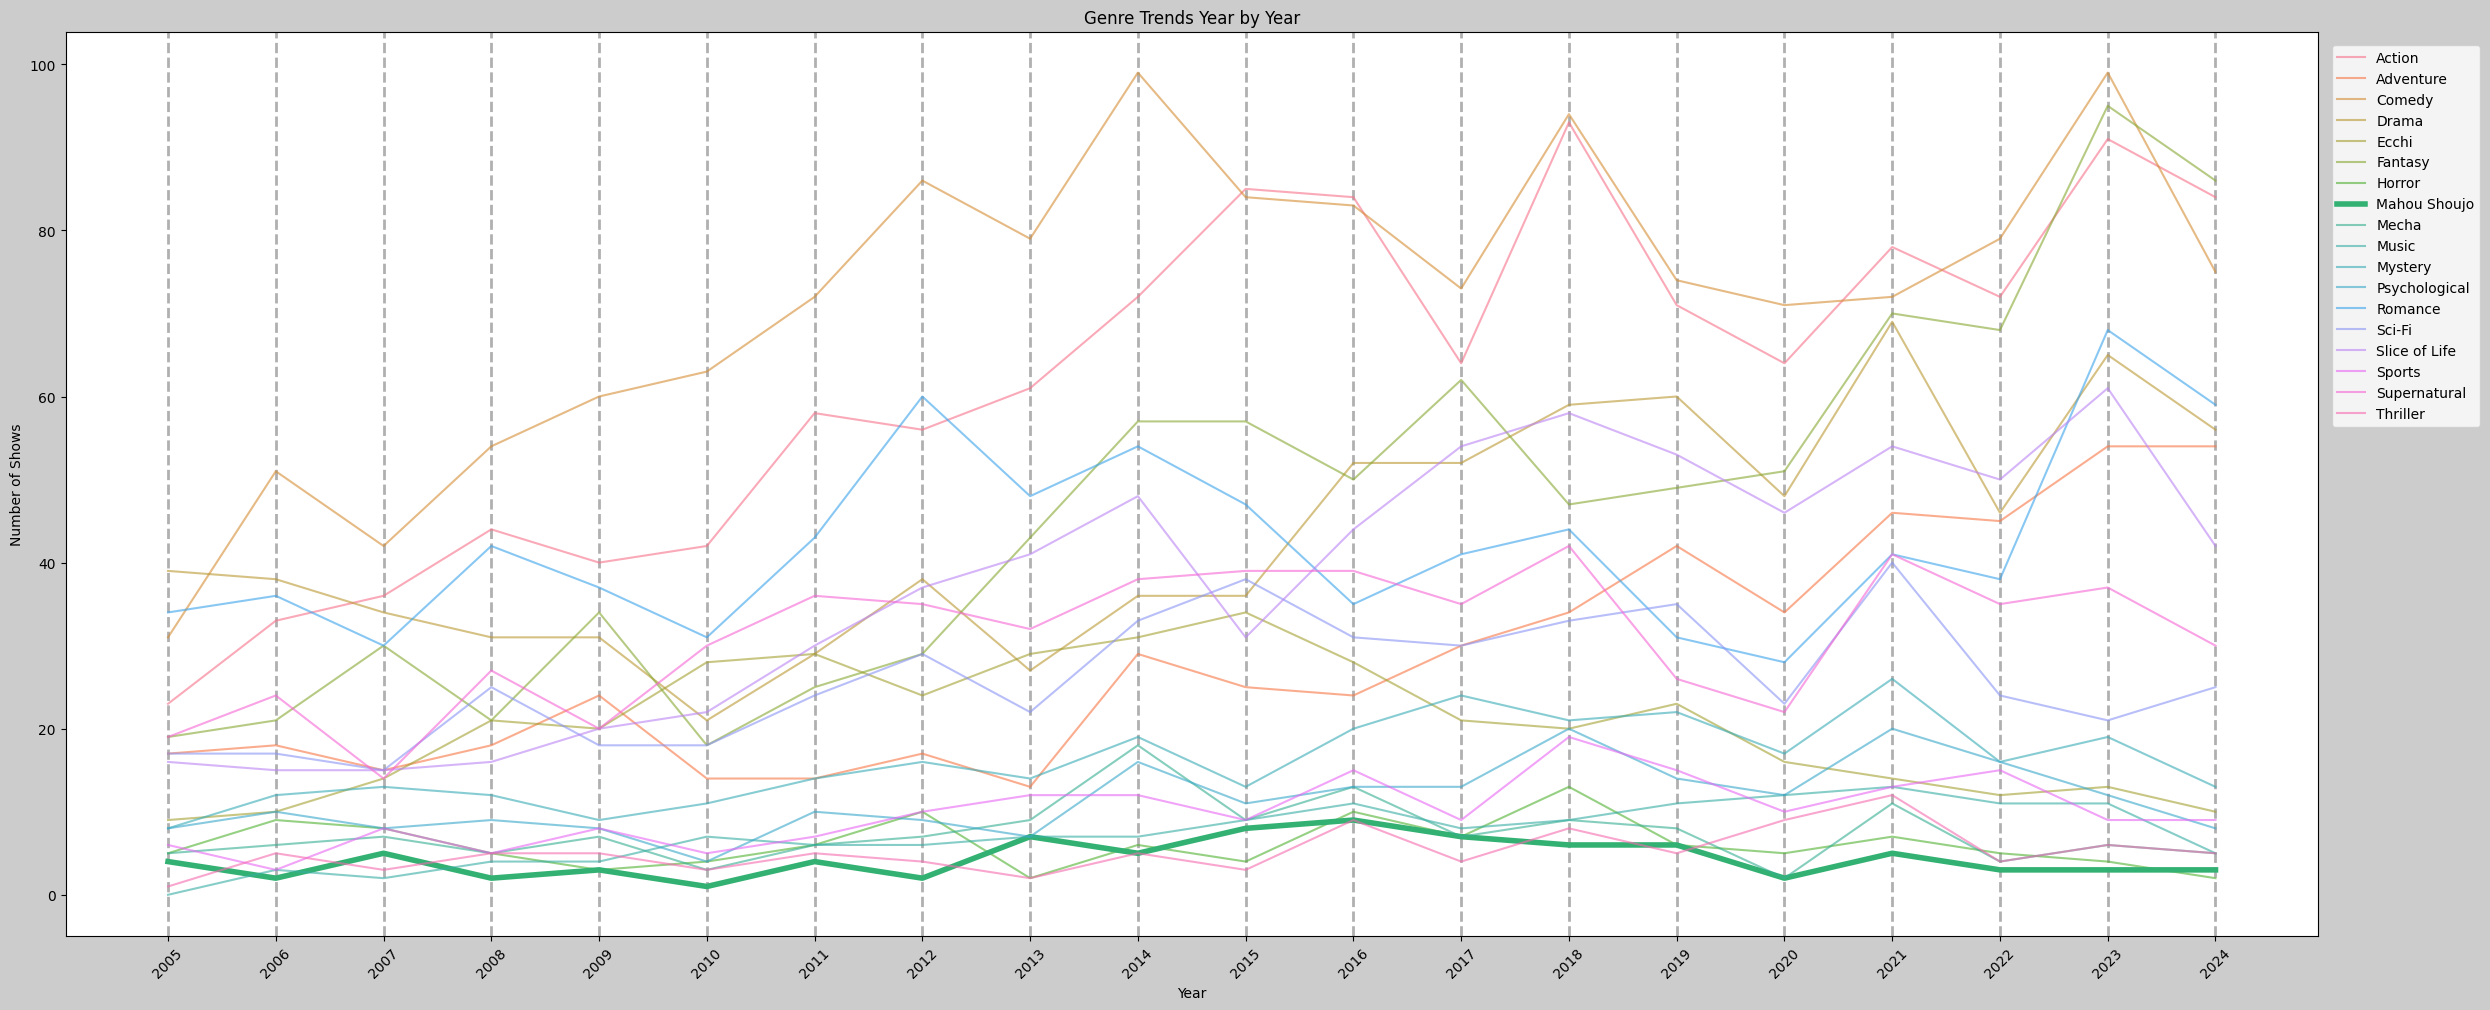

In [ ]:
genre_trends = anilist_genres.pivot_table(values='Title', index='Year', columns='Genres', aggfunc='count', fill_value=0)
colors = sns.color_palette('husl', 18)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')
for i,genre in enumerate(genre_trends.columns):
    if i == 7:
        plt.plot(genre_trends.index, genre_trends[genre], linewidth = 4, label=genre, color=colors[i % len(colors)])
    else:
        plt.plot(genre_trends.index, genre_trends[genre], alpha = 0.6, label=genre, color=colors[i % len(colors)])
plt.title('Genre Trends Year by Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(genre_trends.index), max(genre_trends.index) + 1))
plt.xticks(rotation=45)

plt.show()

In [ ]:
df_year_count = anilist.groupby('Year').Title.count()

In [ ]:
genre_year_count_merge = pd.merge(df_year_count, genre_trends, on='Year',how='outer')
genre_year_count_merge

,Title,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
Year,,,,,,,,,,,,,,,,,,,
2005,70,23,17,31,39,9,19,5,4,5,0,8,8,34,17,16,6,19,1
2006,89,33,18,51,38,10,21,9,2,6,3,12,10,36,17,15,3,24,5
2007,95,36,15,42,34,14,30,8,5,7,2,13,8,30,15,15,8,14,3
2008,108,44,18,54,31,21,21,5,2,5,4,12,9,42,25,16,5,27,5
2009,114,40,24,60,31,20,34,3,3,7,4,9,8,37,18,20,8,20,5
2010,110,42,14,63,21,28,18,4,1,3,7,11,4,31,18,22,5,30,3
2011,133,58,14,72,29,29,25,6,4,6,6,14,10,43,24,30,7,36,5
2012,160,56,17,86,38,24,29,10,2,7,6,16,9,60,29,37,10,35,4
2013,149,61,13,79,27,29,43,2,7,9,7,14,7,48,22,41,12,32,2


Just looking at the raw numbers Mahou Shoujo has had low representation in the industry over all, but there is a clear uptick following the release of 'Madoka Magica' that lasted from 2013 to 2019. A genre that had around two to five shows per year grew to 9 shows in 2016. The difference is even clearer when you look at the trends as a percentage of all shows in the year.

In [ ]:
for column in genre_year_count_merge:
    if column != 'Title':
        genre_year_count_merge[column] = genre_year_count_merge[column]/genre_year_count_merge['Title']*100
genre_percent_by_year = genre_year_count_merge.drop('Title', axis=1)
genre_percent_by_year

,Action,Adventure,Comedy,Drama,Ecchi,Fantasy,Horror,Mahou Shoujo,Mecha,Music,Mystery,Psychological,Romance,Sci-Fi,Slice of Life,Sports,Supernatural,Thriller
Year,,,,,,,,,,,,,,,,,,
2005,32.857143,24.285714,44.285714,55.714286,12.857143,27.142857,7.142857,5.714286,7.142857,0.000000,11.428571,11.428571,48.571429,24.285714,22.857143,8.571429,27.142857,1.428571
2006,37.078652,20.224719,57.303371,42.696629,11.235955,23.595506,10.112360,2.247191,6.741573,3.370787,13.483146,11.235955,40.449438,19.101124,16.853933,3.370787,26.966292,5.617978
2007,37.894737,15.789474,44.210526,35.789474,14.736842,31.578947,8.421053,5.263158,7.368421,2.105263,13.684211,8.421053,31.578947,15.789474,15.789474,8.421053,14.736842,3.157895
2008,40.740741,16.666667,50.000000,28.703704,19.444444,19.444444,4.629630,1.851852,4.629630,3.703704,11.111111,8.333333,38.888889,23.148148,14.814815,4.629630,25.000000,4.629630
2009,35.087719,21.052632,52.631579,27.192982,17.543860,29.824561,2.631579,2.631579,6.140351,3.508772,7.894737,7.017544,32.456140,15.789474,17.543860,7.017544,17.543860,4.385965
2010,38.181818,12.727273,57.272727,19.090909,25.454545,16.363636,3.636364,0.909091,2.727273,6.363636,10.000000,3.636364,28.181818,16.363636,20.000000,4.545455,27.272727,2.727273
2011,43.609023,10.526316,54.135338,21.804511,21.804511,18.796992,4.511278,3.007519,4.511278,4.511278,10.526316,7.518797,32.330827,18.045113,22.556391,5.263158,27.067669,3.759398
2012,35.000000,10.625000,53.750000,23.750000,15.000000,18.125000,6.250000,1.250000,4.375000,3.750000,10.000000,5.625000,37.500000,18.125000,23.125000,6.250000,21.875000,2.500000
2013,40.939597,8.724832,53.020134,18.120805,19.463087,28.859060,1.342282,4.697987,6.040268,4.697987,9.395973,4.697987,32.214765,14.765101,27.516779,8.053691,21.476510,1.342282


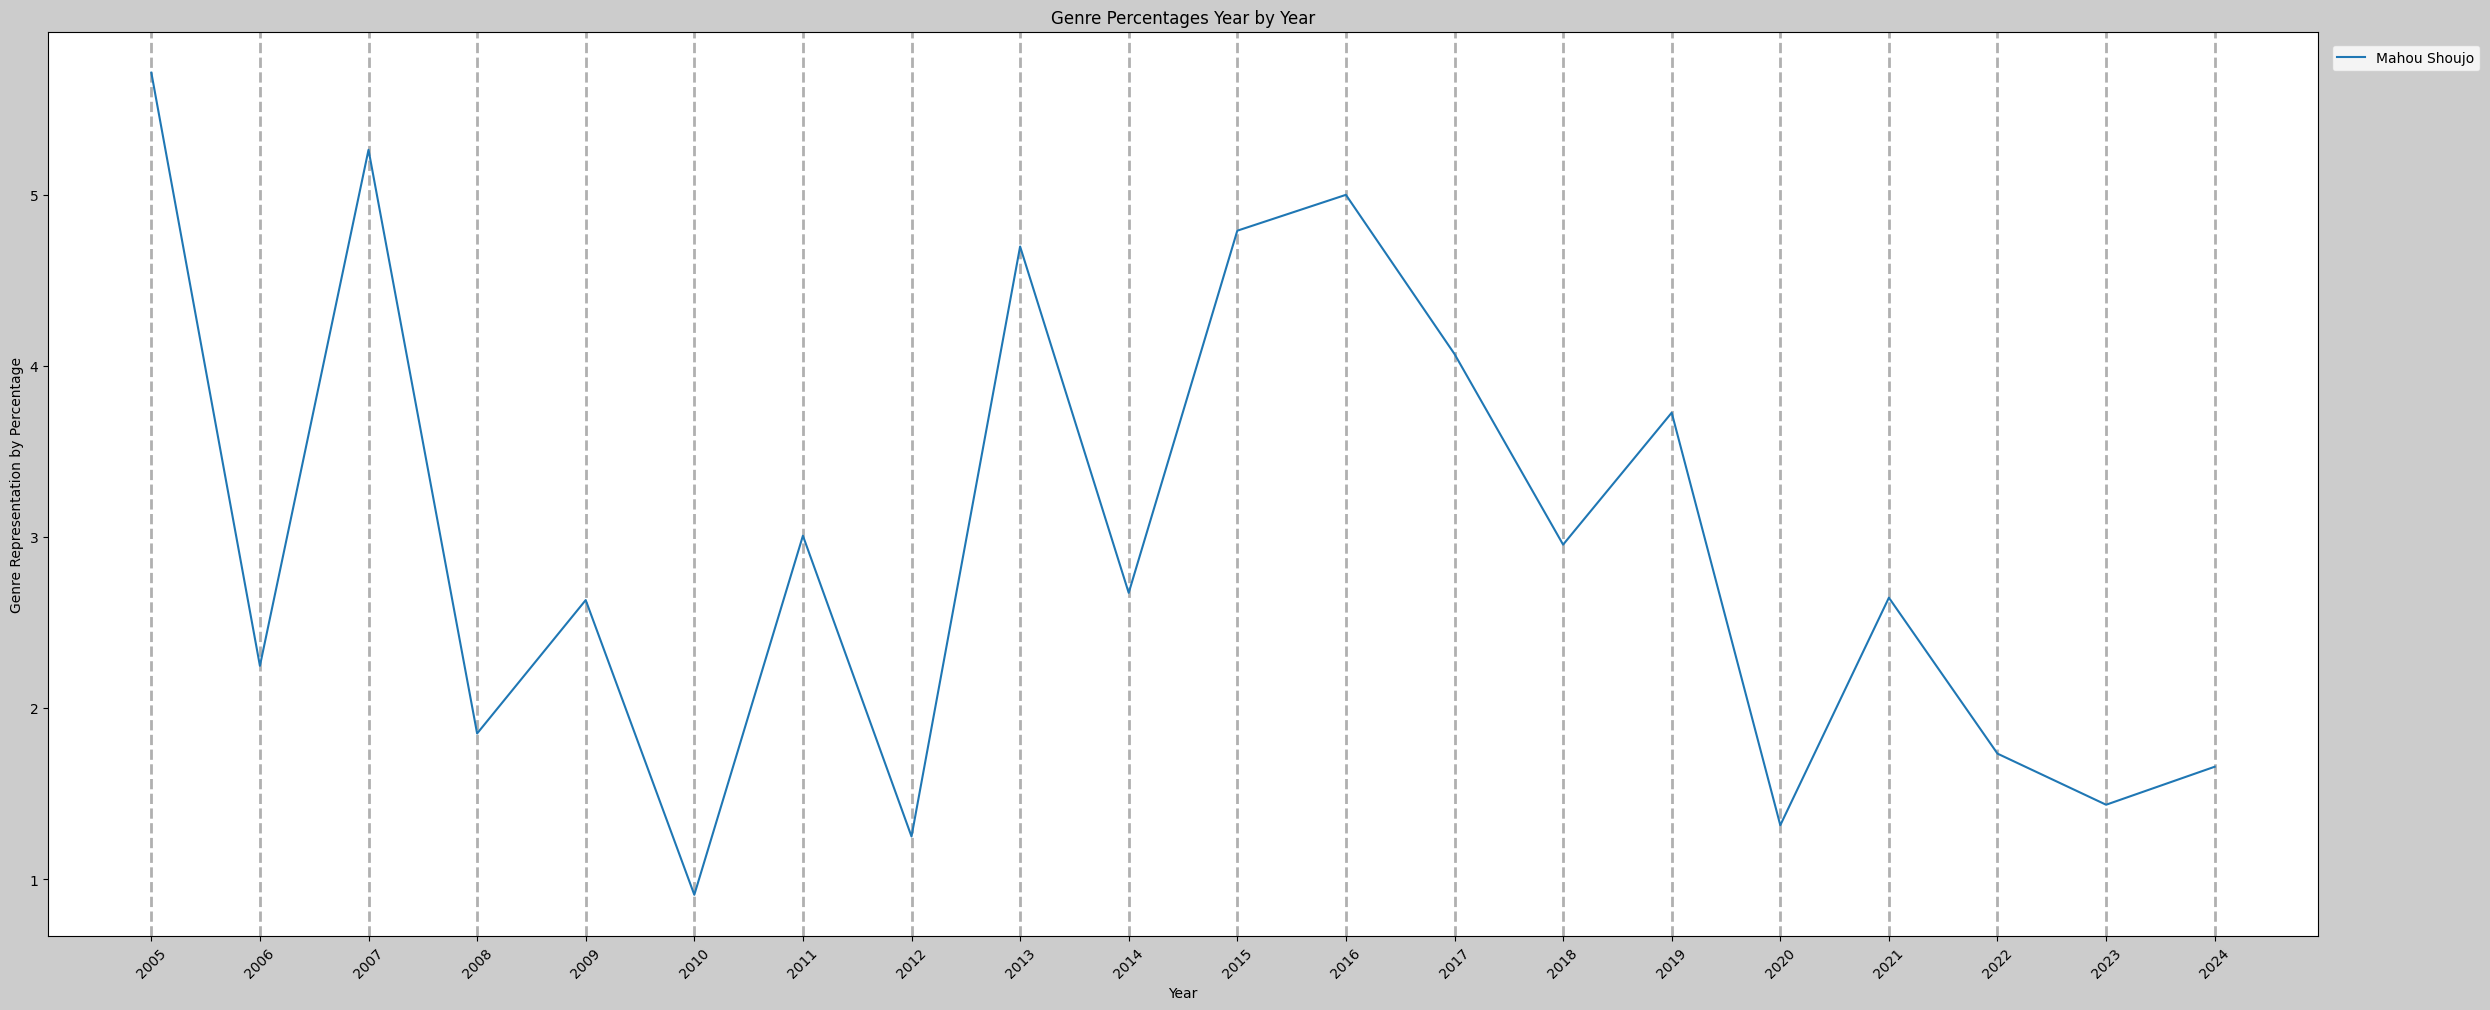

In [ ]:
colors = sns.color_palette('husl', 18)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

plt.plot(genre_percent_by_year.index, genre_percent_by_year['Mahou Shoujo'], label = 'Mahou Shoujo')
plt.title('Genre Percentages Year by Year')
plt.xlabel('Year')
plt.ylabel('Genre Representation by Percentage')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(genre_percent_by_year.index), max(genre_percent_by_year.index) + 1))
plt.xticks(rotation=45)

plt.show()

Here we see that while the raw count of Mahou Shoujo shows were very low up until 2011, percentage wise it was actually on a decline in terms of percentage representation. Starting at around 5 percent in 2005 and falling to 0.9 percent in 2010. While 2011 had a small uptick to 3 percent, we can see it regain its 5 percent share in 2016 following the success of 'Madoka Magica'. Since then, however, the genre has returned to a loss in representation with only 1.6 percent in 2024. It would seem that although the anime industry tried to capitalize on 'Madoka Magica's' success the momentum didn't seem to stick around. Let's look at popularity to find out why.

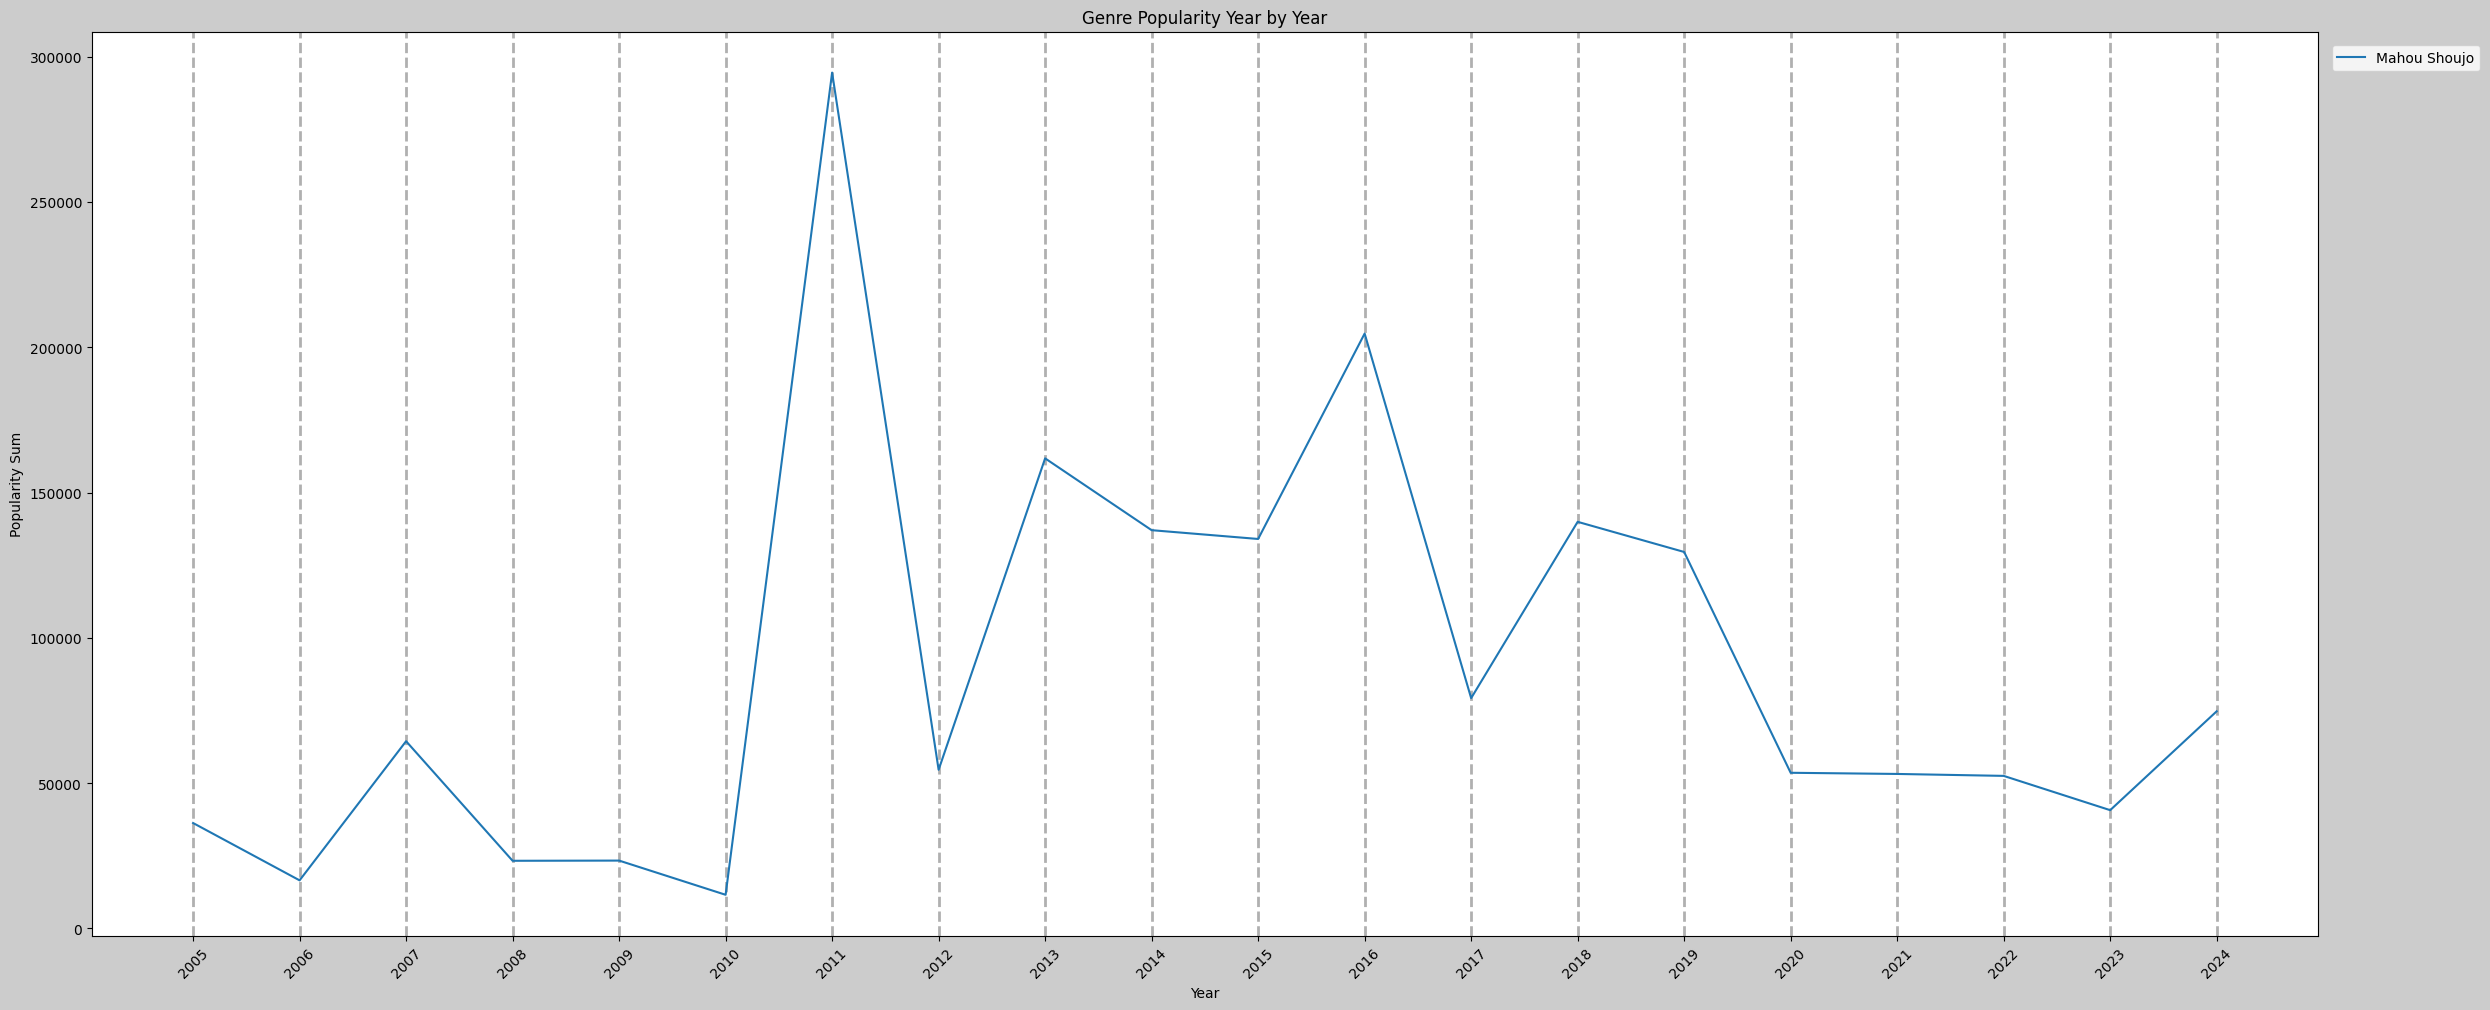

In [ ]:
genre_popularity = anilist_genres.pivot_table(values='Popularity', index='Year', columns='Genres', aggfunc='sum', fill_value=0)
colors = sns.color_palette('husl', 18)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

plt.plot(genre_popularity.index, genre_popularity['Mahou Shoujo'], label = 'Mahou Shoujo')
plt.title('Genre Popularity Year by Year')
plt.xlabel('Year')
plt.ylabel('Popularity Sum')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(genre_popularity.index), max(genre_popularity.index) + 1))
plt.xticks(rotation=45)

plt.show()

Here we can see the large spike in 2011, with the release of 'Madoka Magica', did not translate into continued growth for Mahou Shoujo genre overall. Even with the large jump in number of shows in 2016 there was a decisive drop in overall popularity for the genre. This is likely due to the industries inability to reproduce the same grim dark shock that 'Madoka Magica' is known for. Let's look and see if there are similar trends happening for media tags the community have associated with the shows. 

## Media Tag trends Year by Year:

First we should characterize what a tag is and how it relates to genre. Like genres, tags are categorizations that allow viewers to compare shows that share various qualities and general themes. However, unlike genres, tags are less generalized and more targeted themes, often more associated with the way fan communities discuss shows, rather than how industries may look at them. Again we will need to break down our data into the various tags.

In [ ]:
anilist_tags = anilist
anilist_tags['Tags'] = anilist_tags['Tags'].apply(literal_eval)
anilist_tags = anilist_tags.explode('Tags')
anilist_tags = anilist_tags.dropna(subset=['Tags'])
anilist_tags['Tags'] = anilist_tags['Tags'].apply(lambda x : x['name'])
anilist_tags

,Id,Format,Year,Source,Genres,Popularity,Tags,Title
5,15,TV,2005,MANGA,"[Action, Comedy, Sports]",29079,American Football,Eyeshield 21
5,15,TV,2005,MANGA,"[Action, Comedy, Sports]",29079,Shounen,Eyeshield 21
5,15,TV,2005,MANGA,"[Action, Comedy, Sports]",29079,Male Protagonist,Eyeshield 21
5,15,TV,2005,MANGA,"[Action, Comedy, Sports]",29079,School,Eyeshield 21
5,15,TV,2005,MANGA,"[Action, Comedy, Sports]",29079,Primarily Male Cast,Eyeshield 21
...,...,...,...,...,...,...,...,...
18050,179919,TV,2024,ORIGINAL,"[Drama, Slice of Life, Sports]",21097,Fugitive,Negative Positive Angler
18050,179919,TV,2024,ORIGINAL,"[Drama, Slice of Life, Sports]",21097,Primarily Male Cast,Negative Positive Angler
18050,179919,TV,2024,ORIGINAL,"[Drama, Slice of Life, Sports]",21097,College,Negative Positive Angler
18050,179919,TV,2024,ORIGINAL,"[Drama, Slice of Life, Sports]",21097,Cosplay,Negative Positive Angler


### Disclaimer:

Tag analysis has limitations, as minor themes can inflate a show’s categorization (e.g., DARLING in the FRANXX as an agriculture show despite its minimal focus).

Below is a list of the most popular show associated with each tag. You can spend some time yourself going through the list and finding almost laughable shows associated with an assortment of tags. 

*** NSFW warning: While explicit shows have been excluded from the data some non-explict shows still reference or include NSFW themes. Viewer Advised***


In [ ]:
sort_tag_by_pop = anilist_tags.sort_values(['Tags','Popularity'], ascending=False)
top_tag_pop = sort_tag_by_pop.groupby('Tags').first()[['Title','Year']]
top_tag_pop

,Title,Year
Tags,,
Achromatic,DAN DA DAN,2024
Achronological Order,Death Note,2006
Acrobatics,Life Lessons with Uramichi Oniisan,2021
Acting,Death Note,2006
Adoption,Attack on Titan,2013
...,...,...
Yandere,Death Note,2006
Youkai,JUJUTSU KAISEN,2020
Yuri,My Hero Academia,2016


To address the above issue we will need to narrow down the number of tags that we will look at. We will narrow down the list to a few handpicked tags that have clear stand out shows in their fields with clear themes that small references will be less likely to distract from our analysis. In addition tags that refer primarily to demographic are also excluded as that would be a topic better developed in isolation.

In [ ]:
relevant_tags = [
    'Otaku Culture',
    'Love Triangle', 
    'Kaiju',
    'Cute Girls Doing Cute Things',
    'Isekai',
    'Reincarnation',
    'Iyashikei',
    'Exorcism',
    'Fashion',
    'Super Hero',
    'Super Robot'
    ]

In [ ]:
anilist_tags = anilist_tags[anilist_tags['Tags'].isin(relevant_tags)] #drops rows without the relevant tags

For this section we will turn our focus to one of the more infamous tags, known as 'Isekai'. I will define it first for those not familiar with it. Isekai is the Japanese word for 'another world' so in this context an Isekai show would be one where some of if not the entire plot occurs around a character that has found themselves in a world different from their own. While most often this is a human from our world ending up in some kind of fantasy or sci-fi world, it can also be a being from another world coming to ours, or even from some fantasy world to another fantasy world with no relation to our world. Now like in the genres let’s get a list of the most popular shows in each genre and compare where they all lie in comparison to each other.

In [ ]:
sort_tag_by_pop = anilist_tags.sort_values(['Tags','Popularity'], ascending=False)
top_tag_pop = sort_tag_by_pop.groupby('Tags').first()[['Title','Year']]
top_tag_pop

,Title,Year
Tags,,
Cute Girls Doing Cute Things,Miss Kobayashi's Dragon Maid,2017
Exorcism,JUJUTSU KAISEN,2020
Fashion,My Dress-Up Darling,2022
Isekai,Sword Art Online,2012
Iyashikei,Horimiya,2021
Kaiju,Attack on Titan,2013
Love Triangle,Re:ZERO -Starting Life in Another World-,2016
Otaku Culture,Steins;Gate,2011
Reincarnation,Black Clover,2017


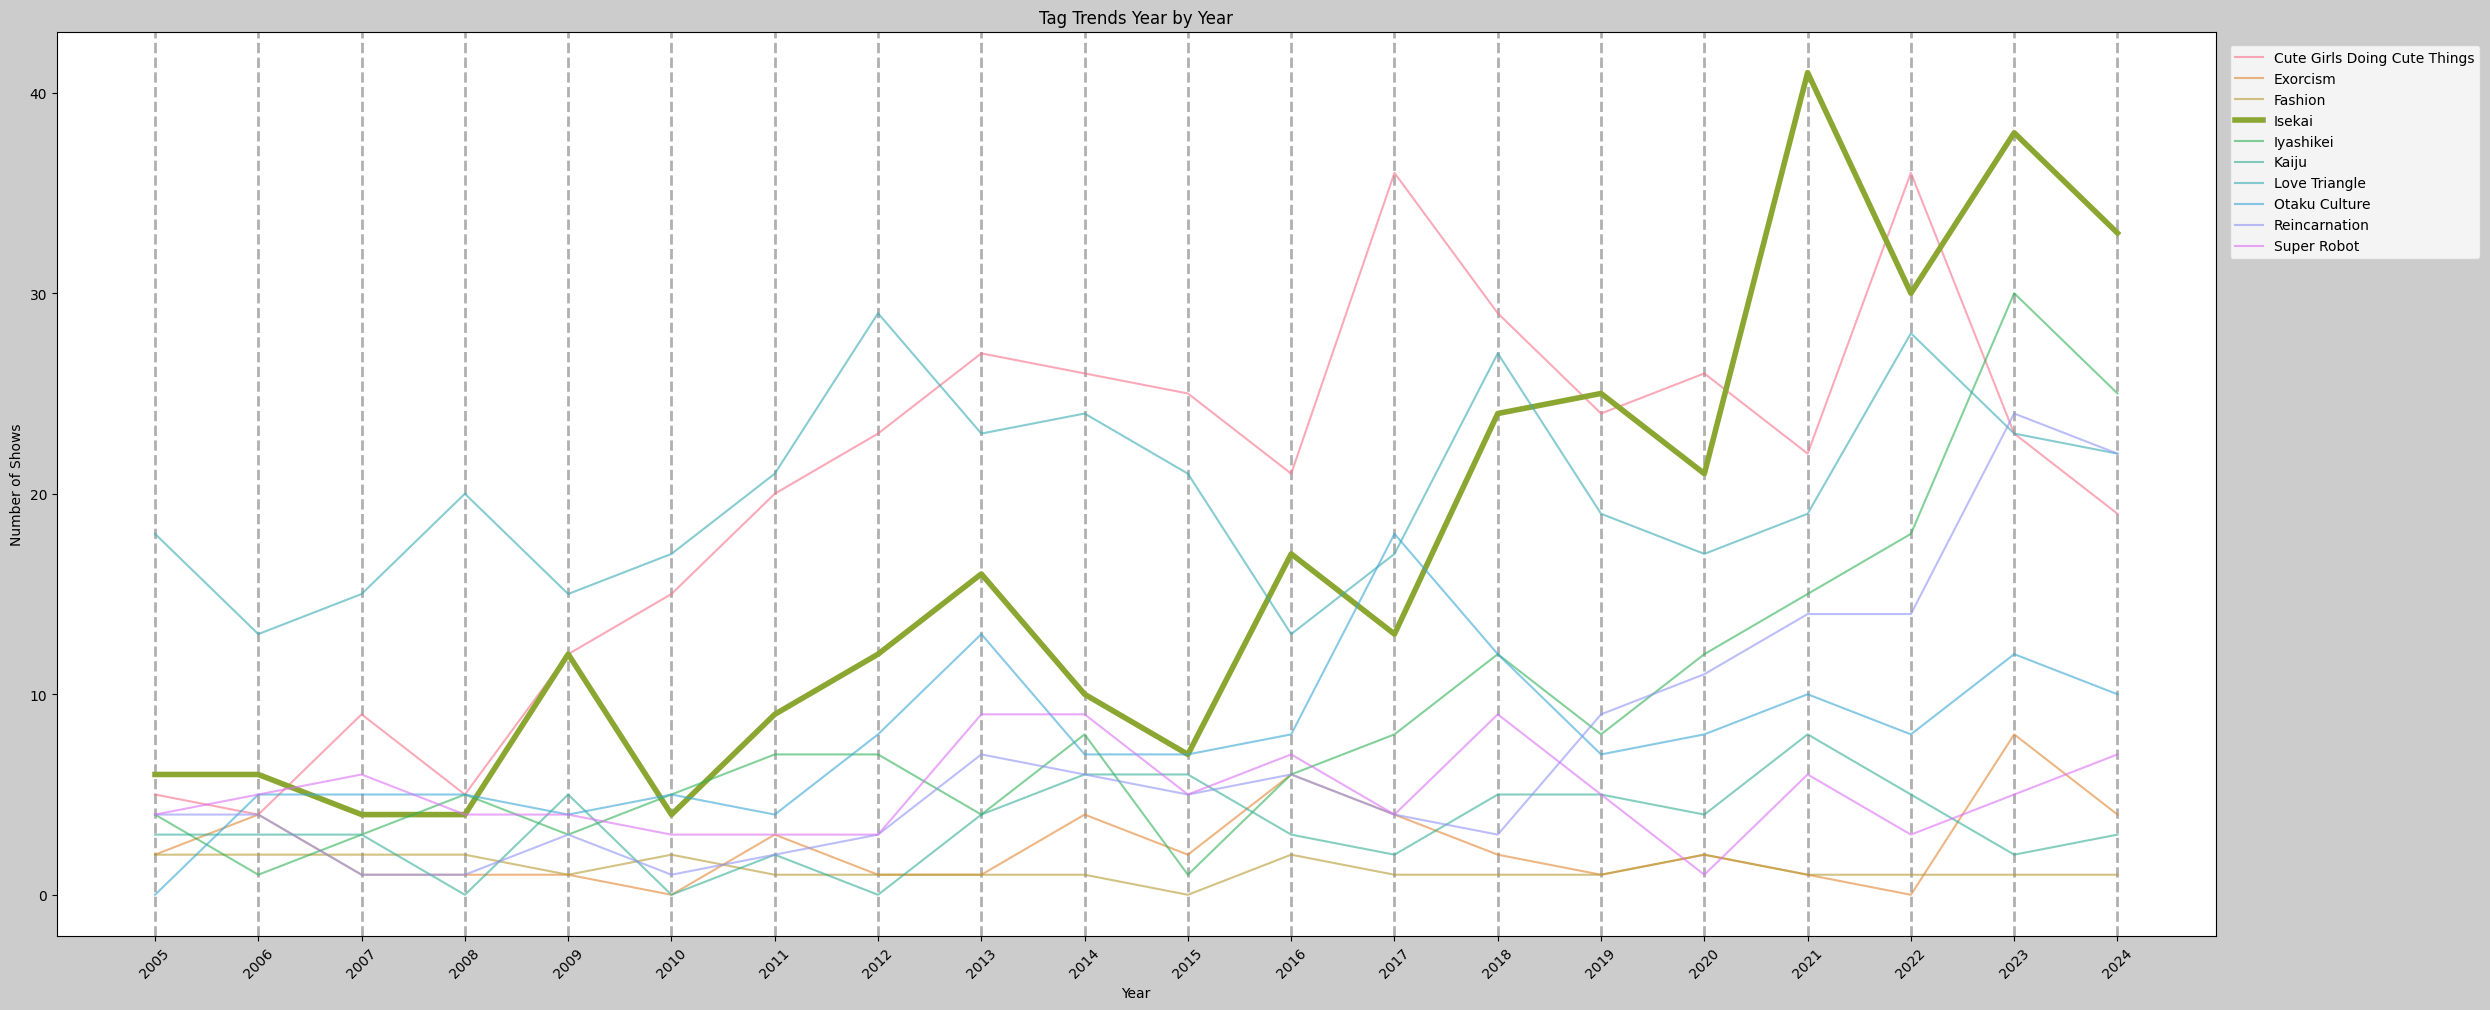

In [ ]:
tag_trends = anilist_tags.pivot_table(values='Title', index='Year', columns='Tags', aggfunc='count', fill_value=0)
colors = sns.color_palette('husl', 11)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')
for i,tag in enumerate(tag_trends.columns):
    if i == 3:
        plt.plot(tag_trends.index, tag_trends[tag], linewidth = 4, label=tag, color=colors[i % len(colors)])
    else:
        plt.plot(tag_trends.index, tag_trends[tag], alpha = 0.6, label=tag, color=colors[i % len(colors)])
plt.title('Tag Trends Year by Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(tag_trends.index), max(tag_trends.index) + 1))
plt.xticks(rotation=45)

plt.show()

In the same way as 'Madoka Magica' and Mahou Shoujo we see a notable increase in Isekai shows following the success of 'Sword Art Online' in 2012. However, unlike 'Madoka Magica', Isekai has seen a continual growth since the release of 'Sword Art Online'. In fact it has out grown all of the other tags we have focused on as the most represented category year by year, finally taking a decisive lead against Cute Girls Doing Cute Things in 2019. Let's narrow our scope to look solely at Isekai as a percentage of shows per year.

In [ ]:
tag_year_count_merge = pd.merge(df_year_count, tag_trends, on='Year',how='outer')
tag_year_count_merge

,Title,Cute Girls Doing Cute Things,Exorcism,Fashion,Isekai,Iyashikei,Kaiju,Love Triangle,Otaku Culture,Reincarnation,Super Robot
Year,,,,,,,,,,,
2005,70,5,2,2,6,4,3,18,0,4,4
2006,89,4,4,2,6,1,3,13,5,4,5
2007,95,9,1,2,4,3,3,15,5,1,6
2008,108,5,1,2,4,5,0,20,5,1,4
2009,114,12,1,1,12,3,5,15,4,3,4
2010,110,15,0,2,4,5,0,17,5,1,3
2011,133,20,3,1,9,7,2,21,4,2,3
2012,160,23,1,1,12,7,0,29,8,3,3
2013,149,27,1,1,16,4,4,23,13,7,9


In [ ]:
for column in tag_year_count_merge:
    if column != 'Title':
        tag_year_count_merge[column] = tag_year_count_merge[column]/tag_year_count_merge['Title']*100
tag_percent_by_year = tag_year_count_merge.drop('Title', axis=1)
tag_percent_by_year

,Cute Girls Doing Cute Things,Exorcism,Fashion,Isekai,Iyashikei,Kaiju,Love Triangle,Otaku Culture,Reincarnation,Super Robot
Year,,,,,,,,,,
2005,7.142857,2.857143,2.857143,8.571429,5.714286,4.285714,25.714286,0.000000,5.714286,5.714286
2006,4.494382,4.494382,2.247191,6.741573,1.123596,3.370787,14.606742,5.617978,4.494382,5.617978
2007,9.473684,1.052632,2.105263,4.210526,3.157895,3.157895,15.789474,5.263158,1.052632,6.315789
2008,4.629630,0.925926,1.851852,3.703704,4.629630,0.000000,18.518519,4.629630,0.925926,3.703704
2009,10.526316,0.877193,0.877193,10.526316,2.631579,4.385965,13.157895,3.508772,2.631579,3.508772
2010,13.636364,0.000000,1.818182,3.636364,4.545455,0.000000,15.454545,4.545455,0.909091,2.727273
2011,15.037594,2.255639,0.751880,6.766917,5.263158,1.503759,15.789474,3.007519,1.503759,2.255639
2012,14.375000,0.625000,0.625000,7.500000,4.375000,0.000000,18.125000,5.000000,1.875000,1.875000
2013,18.120805,0.671141,0.671141,10.738255,2.684564,2.684564,15.436242,8.724832,4.697987,6.040268


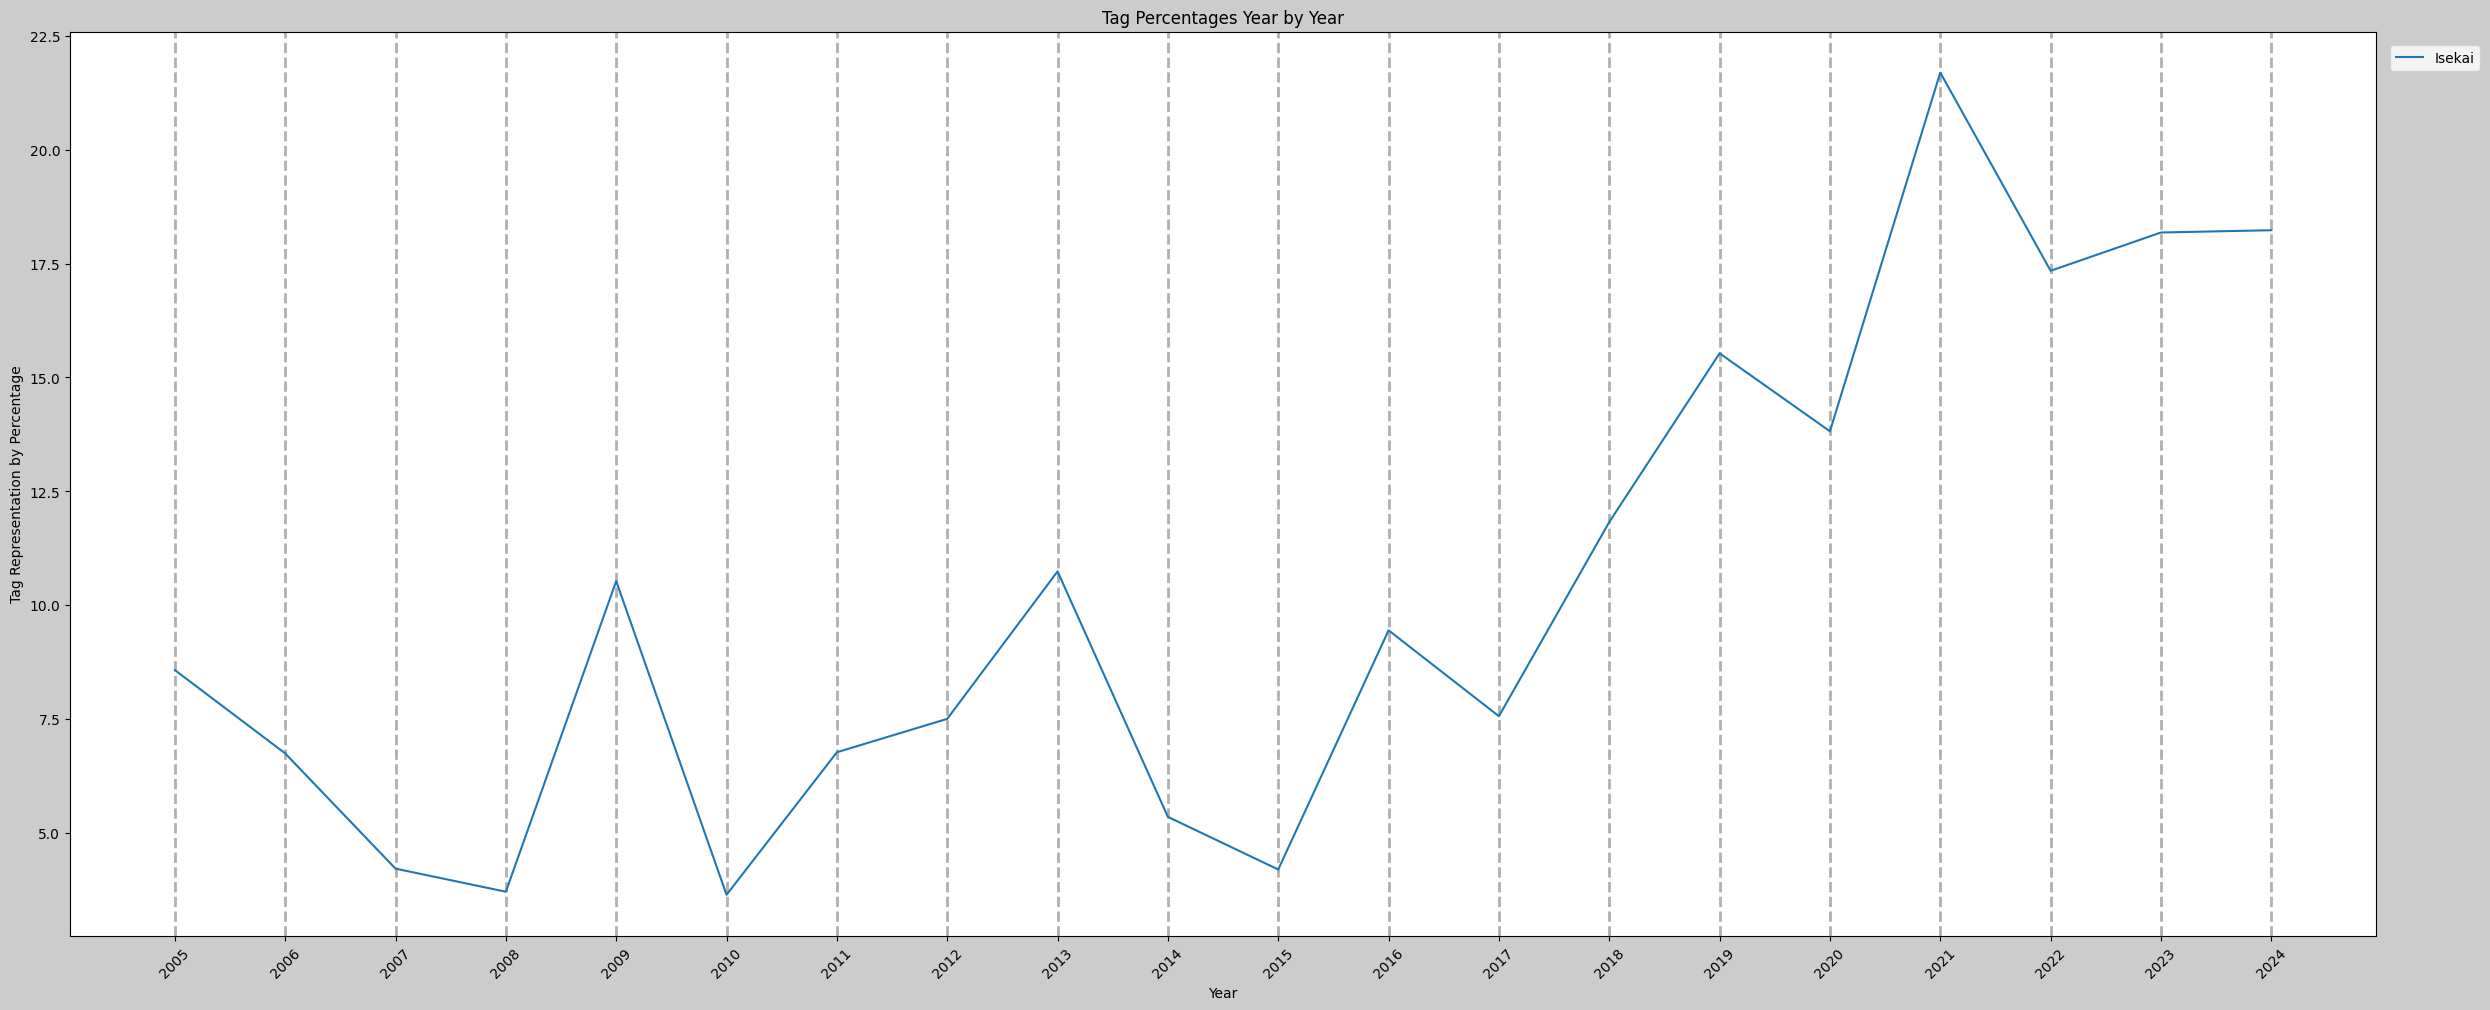

In [ ]:
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

plt.plot(tag_percent_by_year.index, tag_percent_by_year['Isekai'], label = 'Isekai')
plt.title('Tag Percentages Year by Year')
plt.xlabel('Year')
plt.ylabel('Tag Representation by Percentage')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(tag_percent_by_year.index), max(tag_percent_by_year.index) + 1))
plt.xticks(rotation=45)

plt.show()

Here we see that while there was a hesitation to fully commit to the Isekai boom in 2014 and 2015 (just after Attack on Titan premiered in 2013), Isekai has since seen rapid growth in the industry and became a mainstay. Seeing growth as high as 21.6 percent share in 2021 and maintaining near 19 percent representation ever since. This hasn't been without controversy, as with the increase of light novel representation we looked at earlier there has been a frequent outcry in the community that the industry is cranking out bad shows for easy wins. Let's look at how interest in the category has changed as the number of shows have grown.

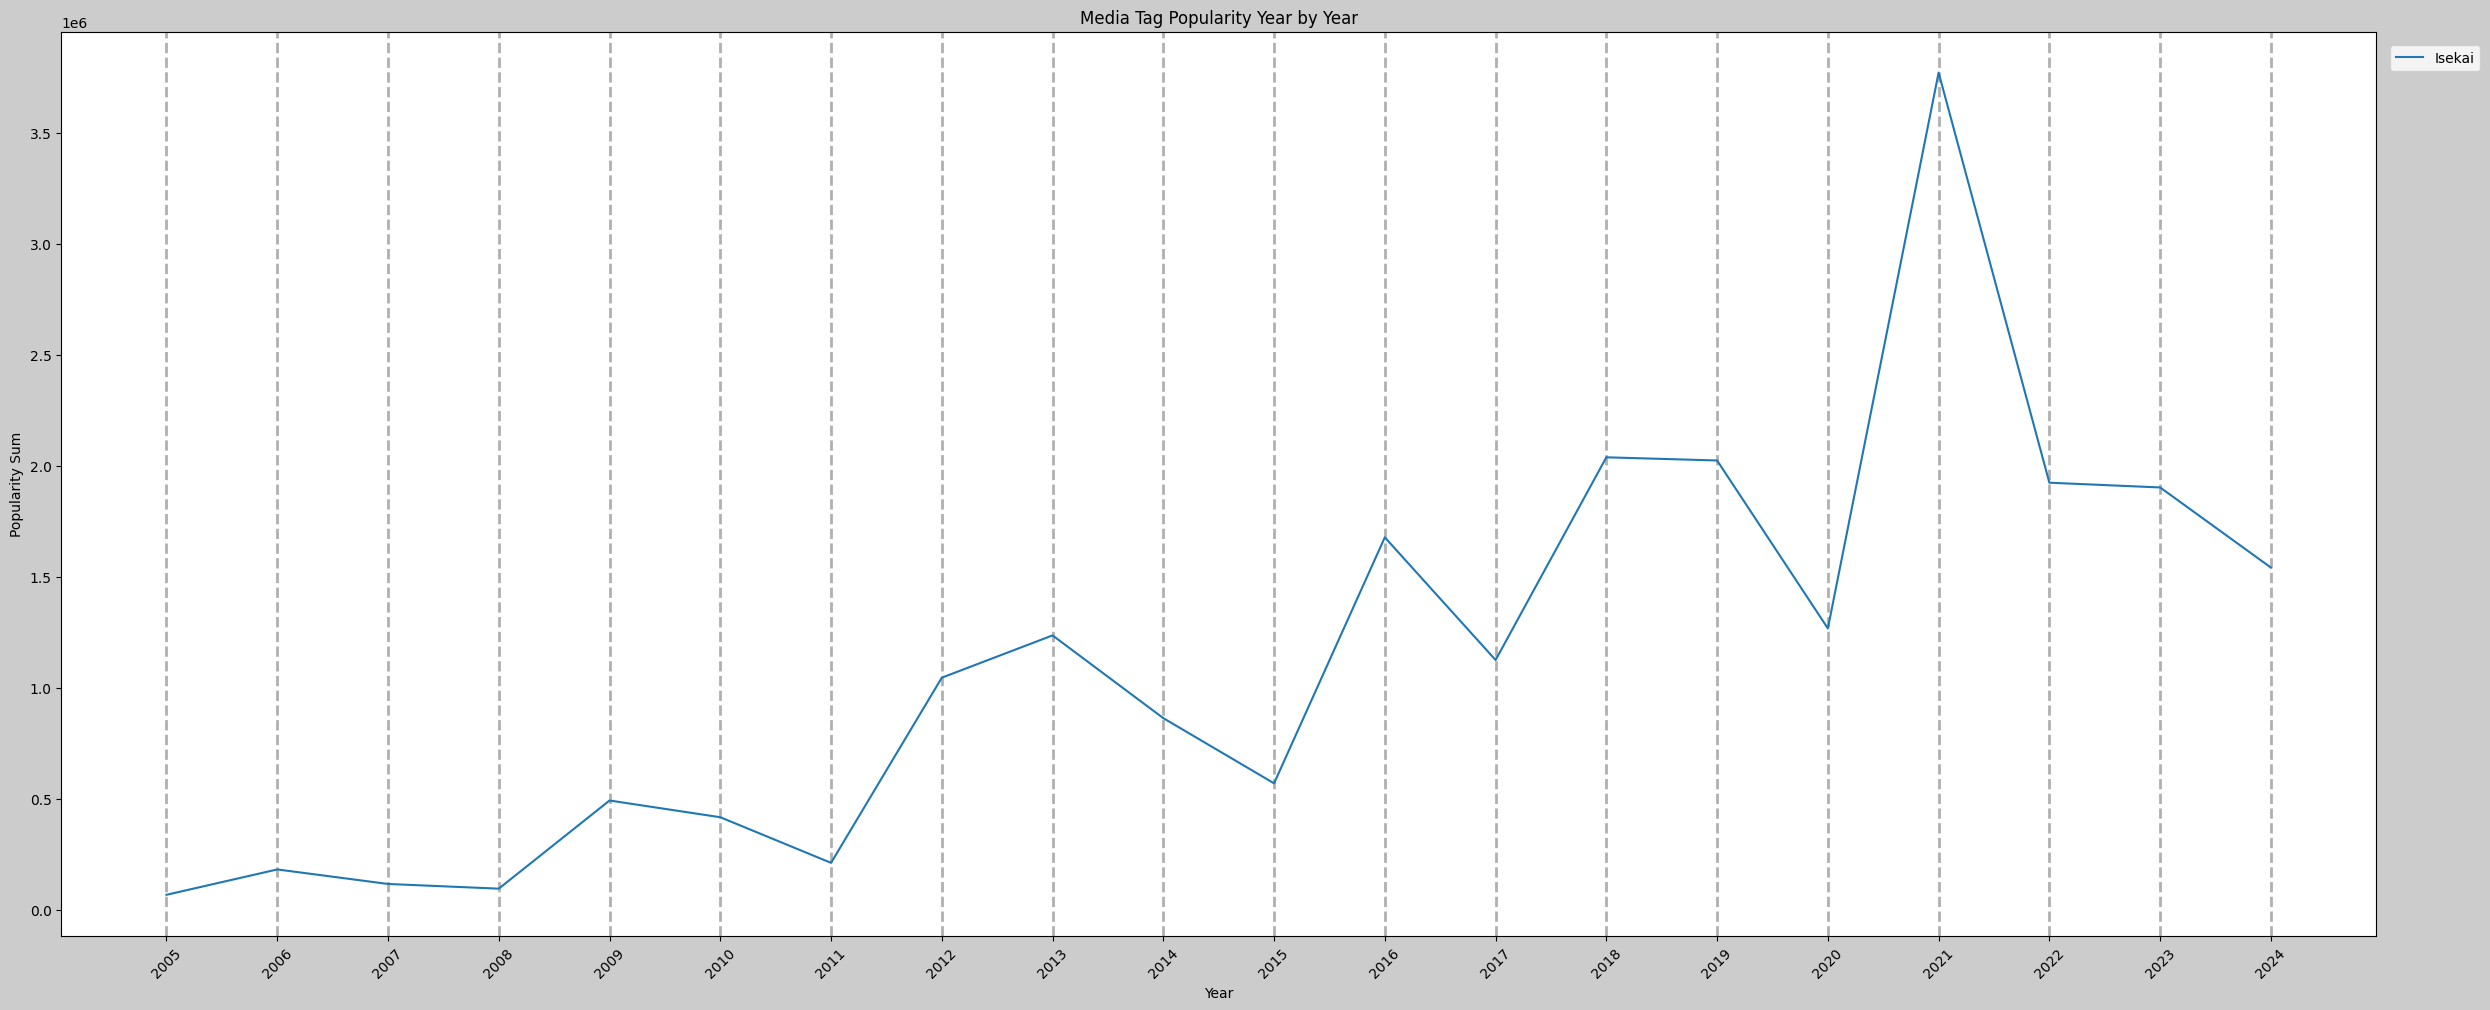

In [ ]:
tag_popularity = anilist_tags.pivot_table(values='Popularity', index='Year', columns='Tags', aggfunc='sum', fill_value=0)
#colors = sns.color_palette('husl', 11)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

plt.plot(tag_popularity.index, tag_popularity['Isekai'], label = 'Isekai')
plt.title('Media Tag Popularity Year by Year')
plt.xlabel('Year')
plt.ylabel('Popularity Sum')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(tag_popularity.index), max(tag_popularity.index) + 1))
plt.xticks(rotation=45)

plt.show()

Here we see that since 'Sword Art Online' put Isekai on the map in 2012, the overall popularity of the category has continued to grow. While it might be argued that the continued popularity is a manufactured trend, due to the large number of shows, the trends we saw in the Mahou Shoujo genre reflects that just increasing representation in a category does not easily result in continued popularity. We can confirm this by looking at how the popularity of this category compares to other trends.

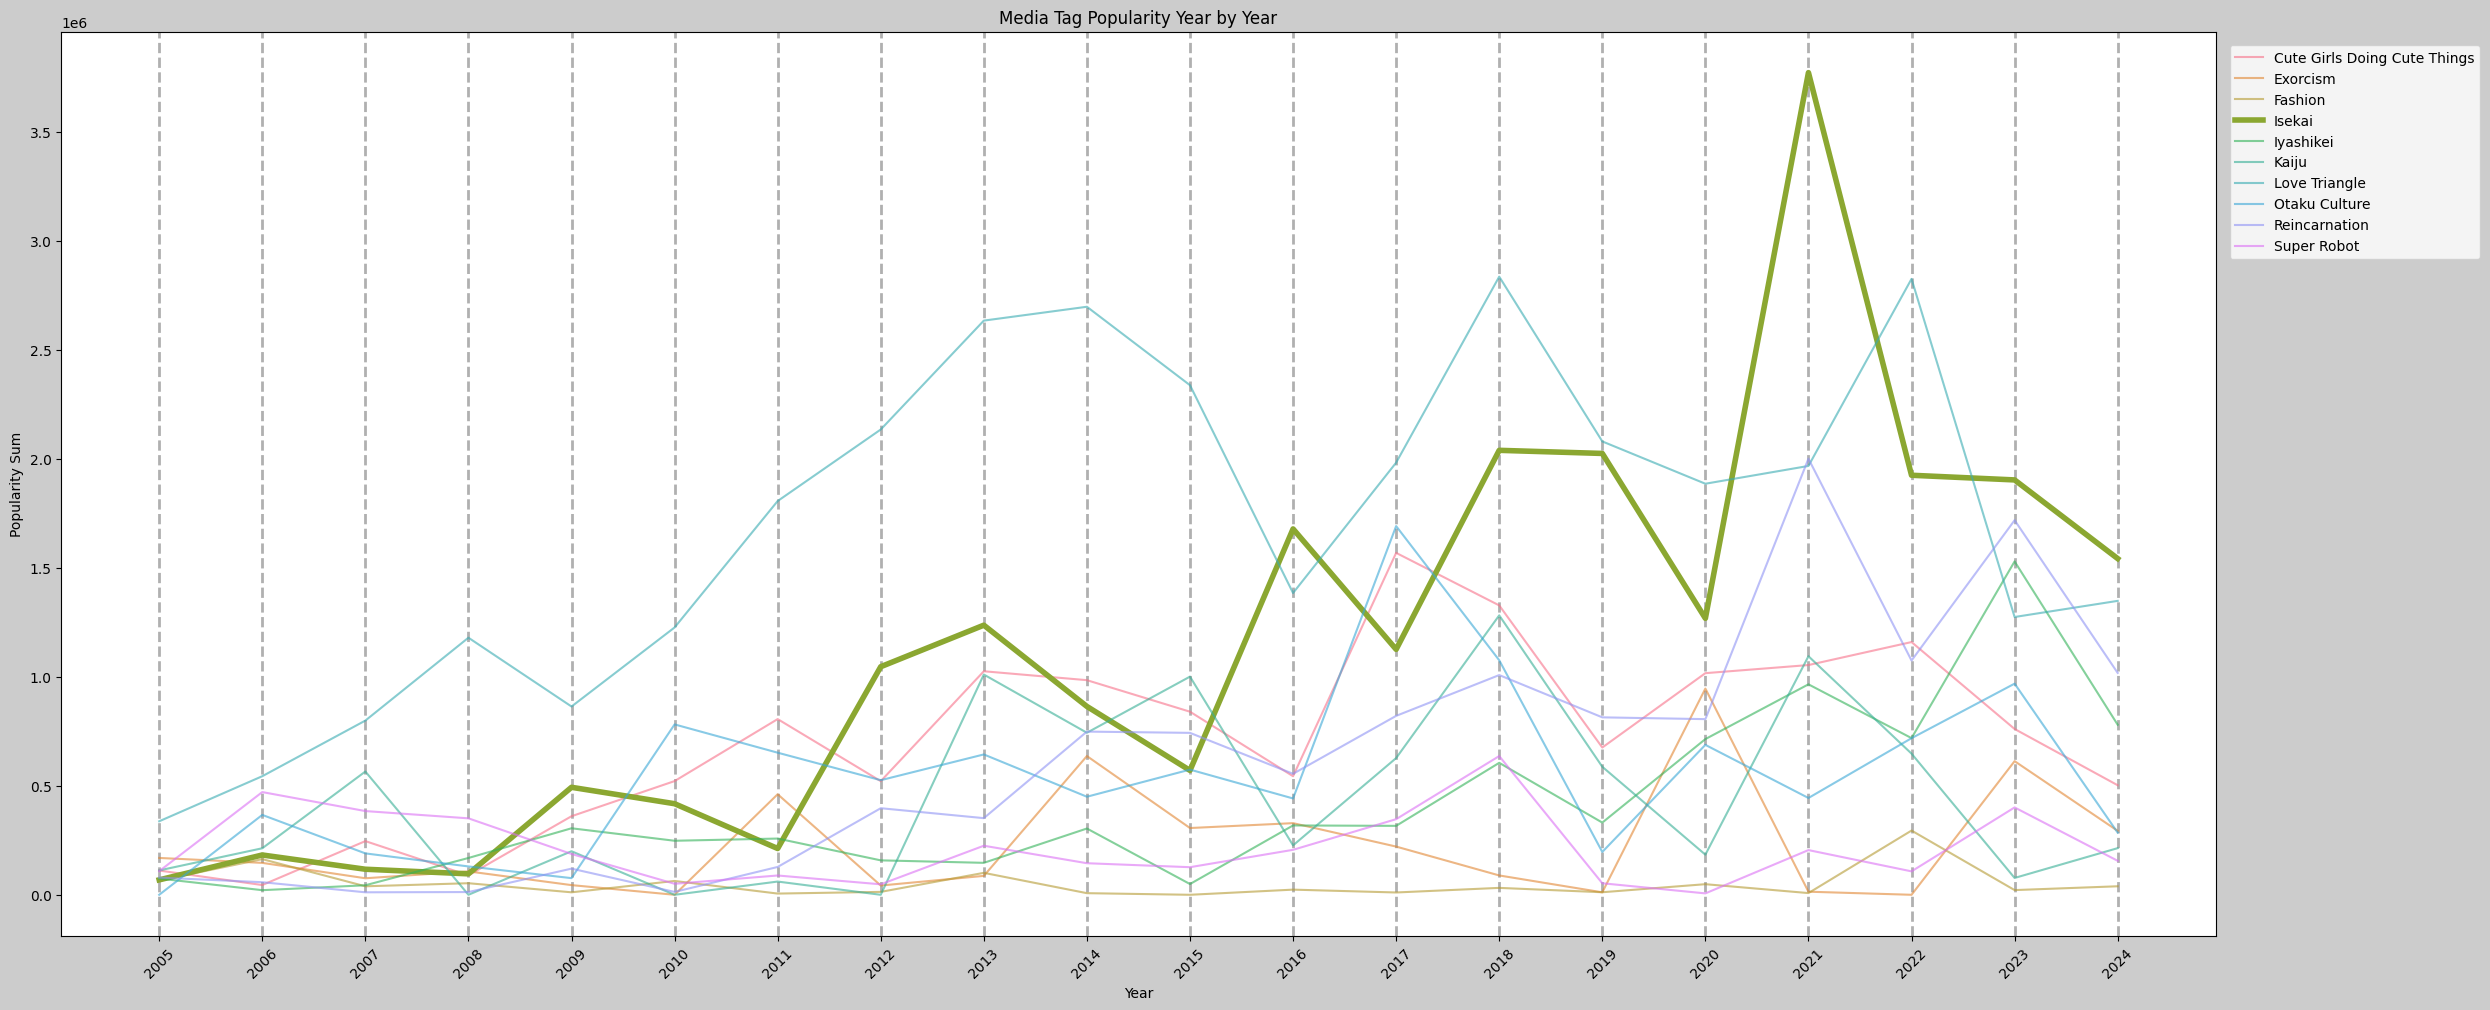

In [ ]:
tag_popularity = anilist_tags.pivot_table(values='Popularity', index='Year', columns='Tags', aggfunc='sum', fill_value=0)
colors = sns.color_palette('husl', 11)
# Plotting
plt.figure(figsize=(25, 10),facecolor='#cccccc')

for i,tag in enumerate(tag_popularity.columns):
    if i == 3:
        plt.plot(tag_popularity.index, tag_popularity[tag], linewidth = 4, label=tag, color=colors[i % len(colors)])
    else:
        plt.plot(tag_popularity.index, tag_popularity[tag], alpha = 0.6, label=tag, color=colors[i % len(colors)])
plt.title('Media Tag Popularity Year by Year')
plt.xlabel('Year')
plt.ylabel('Popularity Sum')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1.)
plt.grid(True, which='both', axis='x', linestyle='--', linewidth=2)
plt.tight_layout()

plt.xticks(range(min(tag_popularity.index), max(tag_popularity.index) + 1))
plt.xticks(rotation=45)

plt.show()

Here we see that Isekai has held a sizable amount of realestate in the anime community’s minds despite the often lamented oversaturation. The reality is that despite the vocal anime community's protests of the quality of Isekai shows, the anime fandom at large is still captured by the general escapism and heroic wish fulfillment character writing present in the majority of Isekai shows.

While one could argue looking only at the spike in 2021 and the drop off in years that followed that perhaps Isekai has reached an inflection point for audience retention. While confirming this trend will likely take several more years to see any real change, the continued increase in the production of Isekai shows tells us that the industry as a whole is still bullish on the genre. 

As an addendum here is a list of all the shows from 2021 marked as Isekai, in case you want to see a good picture as to why 2021 may have been a standout year.


In [ ]:
isekai_by_pop = anilist_tags[anilist_tags['Tags'] == 'Isekai']
isekai_2021_by_pop = isekai_by_pop[isekai_by_pop['Year'] == 2021]
isekai_2021_by_pop = isekai_2021_by_pop.drop(['Format', 'Source', 'Genres'], axis=1)
isekai_2021_by_pop.sort_values(['Popularity'], ascending=False)

,Id,Year,Popularity,Tags,Title
11038,108465,2021,338939,Isekai,Mushoku Tensei: Jobless Reincarnation
11042,108511,2021,249230,Isekai,That Time I Got Reincarnated as a Slime Season 2
13101,124845,2021,241980,Isekai,WONDER EGG PRIORITY
13412,127720,2021,240969,Isekai,Mushoku Tensei: Jobless Reincarnation Cour 2
12516,119661,2021,229890,Isekai,Re:ZERO -Starting Life in Another World- Seaso...
12210,116742,2021,205565,Isekai,That Time I Got Reincarnated as a Slime Season...
13714,129898,2021,150028,Isekai,The World's Finest Assassin Gets Reincarnated ...
10942,107717,2021,140885,Isekai,Miss Kobayashi's Dragon Maid S
13120,125206,2021,121327,Isekai,TSUKIMICHI -Moonlit Fantasy-
10173,103632,2021,120106,Isekai,"So I'm a Spider, So What?"


# Conclusions:

## Summary:

As we conclude our analysis we can see a couple of interesting conclusions for the anime industry. Namely, we can see the growth that light novel shows have had in comparison to original content. Meanwhile, we can see both the positive and negative possible outcomes that can arise when the industry tries to capitalize on a breakout show. 

## Implications for the Industry:

The rescent rise in light novel content has clear justification over the risk of original content, as we can see a clear sustained popularity in the former. Also while a breakout show could result in a sustiained popularity like in 'Sword Art Online' it can also fail to produce that success if the industry is unable to recreate the successful themes of shows like 'Madoka Magica'.

## Alignment with the Anime Community

It would seem that the industry has a better hold on the anime community at large than the vocal anime community would have you believe. There has been a strong growth and maitenence in popularity for both light novels and isekai, despite fans voiceing stagnation and oversaturation in both. Although we can see the fans can get it right as the industry was unable to capitalize on the grim dark atmosphere of 'Madoka Magica' to boost the popularity of the Mahou Shoujo genre.

## Final Thoughts

Thanks for following me on this short journey of anime industry trends over the last 20 years. I think we have learned a lot about how the industry makes decisions on what they belive will draw the largest audiences. While the general community sentiment seldom reflects the hard data on what is popular and what is not, it is important for the industy to keep and eye on these sentiments so they don't repeat mistakes like all of the 'Madoka Magica' look-alikes.